# Imports

In [2]:
import torch
import os

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import fishvae

In [5]:
from vector_cv_tools import transforms as VT
import albumentations as A
from albumentations.pytorch import ToTensorV2
from vector_cv_tools import datasets as vdatasets
MVTEC_ROOT_DIR = "/scratch/ssd002/datasets/MVTec_AD"
basic_transform = VT.ComposeMVTecTransform([A.Resize(128, 128), A.ToFloat(max_value=255), ToTensorV2()])
dset = vdatasets.MVTec(MVTEC_ROOT_DIR, split="train", transforms = basic_transform)

In [6]:
from matplotlib.animation import FuncAnimation
import numpy as np

In [14]:
from IPython.display import HTML

In [15]:
fishmodel = torch.nn.DataParallel(fishvae.FishVAE())

### Tests and jibber jabber

In [5]:
%time fishmodel = torch.nn.DataParallel(fishvae.FishVAE())

CPU times: user 3.21 s, sys: 1.48 s, total: 4.69 s
Wall time: 5.02 s


In [8]:
%time fishmodel.load_state_dict(torch.load("/checkpoint/ttrim/fishae/fishvae_v1_lmda0.5_epo500.pt"))

CPU times: user 104 ms, sys: 399 ms, total: 503 ms
Wall time: 1.07 s


<All keys matched successfully>

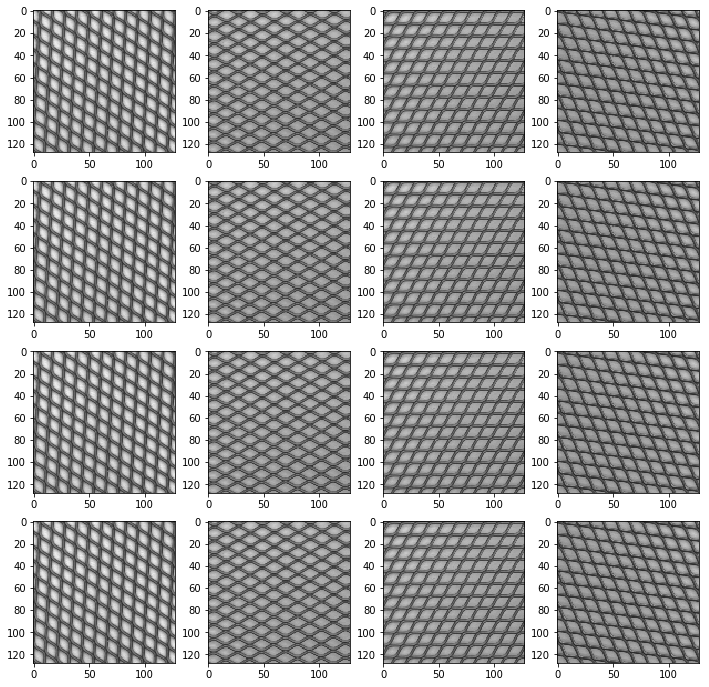

In [27]:
# grid_imgs
grid_imgs(
    dset[1000][0],
    dset[1001][0],
    dset[1002][0],
    dset[1003][0],
    dset[1000][0],
    dset[1001][0],
    dset[1002][0],
    dset[1003][0],
    dset[1000][0],
    dset[1001][0],
    dset[1002][0],
    dset[1003][0],
    dset[1000][0],
    dset[1001][0],
    dset[1002][0],
    dset[1003][0],
    shape=(4,4)
    )
plt.show()

# helper func

In [8]:
def loadmod(fln):
    fishmodel.load_state_dict(torch.load(fln))
    fishmodel.module.eval()# probs doesn't need done ever time

In [9]:
def grid_imgs(*imgs,shape=None):
    if shape is None:
        shape = (1,len(imgs))
    plt.rcParams["figure.figsize"] = (shape[0]*3,shape[1]*3)
    for i in range(len(imgs)):
        plt.subplot(shape[1],shape[0],i+1)
        single_img = imgs[i].permute(1,2,0).cpu().numpy()
        plt.imshow(single_img)

In [10]:
def img2vec(img):
    imgpu = img.unsqueeze(0).to("cuda")
    with torch.no_grad():
        z = fishmodel.module.encoder(imgpu)
    return z[..., :100] # we only like mu
def vec2img(vec):
    with torch.no_grad():
        img = fishmodel.module.decoder(vec.unsqueeze(-1).unsqueeze(-1))
        img = img.squeeze(0)
    return img
def img2img(img):
    return(vec2img(img2vec(img)))

# Do the stuff

In [24]:
files = (["/checkpoint/ttrim/fishae/"+_ for _ in os.listdir("/checkpoint/ttrim/fishae")] +
        ["/checkpoint/ttrim/fishae2/"+_ for _ in os.listdir("/checkpoint/ttrim/fishae2")])
filenamelist = list( fl for fl in files if "lmda1" in fl)
print(len(filenamelist))
filenamelist.reverse()

7


CPU times: user 45 µs, sys: 24 µs, total: 69 µs
Wall time: 74.1 µs
0
0


/pkgs/vector_cv_project/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


1
2
3
4
5
6
CPU times: user 15.6 s, sys: 8.3 s, total: 23.9 s
Wall time: 25.7 s


0


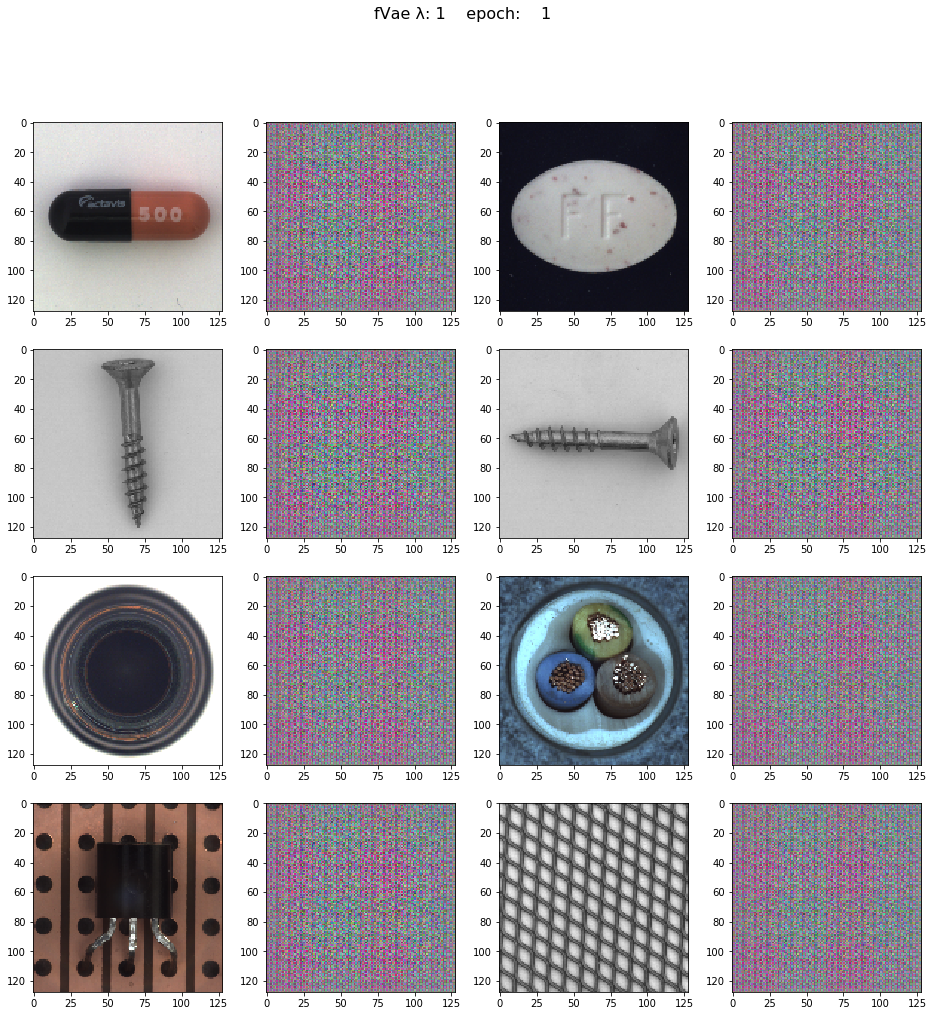

In [25]:
#### This does a video of one model as specified above reconstructing each of the 8 samples in the ind list
#### over the training using the availiable checkpoints
def update(j):
    
    print(j)
    
    loadmod(filenamelist[j])
    
    epoch_name = filenamelist[j].split("_epo")[-1].split(".")[0].rjust(4)
    lambda_name = filenamelist[j].split("_lmda")[-1].split("_")[0].ljust(4)
    fig.suptitle(f"fVae λ: {lambda_name} epoch: {epoch_name}", fontsize=16)
    #plt.title(filenamelist[j].split("_")[-1].split(".")[0].rjust(6))
    
    imgs = []
    for ind in (500,2100,2578,2516,100,300,3100,1000):
        imgs+=[dset[ind][0],
               img2img(dset[ind][0])
              ]
    grid_imgs(*imgs,shape=(4,4))
    #plt.imshow(single_img)


plt.rcParams["figure.figsize"] = (16,16)
fig, ax = plt.subplots()

%time anim = FuncAnimation(fig, update, frames=np.arange(len(filenamelist)), interval=50)

%time HTML(anim.to_html5_video())

# Wait here for animation rendering